# 一、使用IMDB資料集訓練模型

In [1]:
from keras.datasets import imdb
from keras import preprocessing

max_unique_tokens = 20000 # 取前20000個字來建立特徵維度
max_DocLen = 200 # 限定文件長度度為前200字

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words= max_unique_tokens)

In [2]:
train_data = preprocessing.sequence.pad_sequences(train_data, maxlen=max_DocLen, truncating='post', padding='post')
test_data = preprocessing.sequence.pad_sequences(test_data, maxlen=max_DocLen, truncating='post', padding='post')
# print(train_data.shape)
# print(test_data.shape)

In [3]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(max_unique_tokens, 300, input_length=max_DocLen))
model.add(Flatten())
model.add(Dense(16, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))

# model.layers[0].set_weights([w2v_embedding_matrix])
# model.layers[0].trainable = False

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 300)          6000000   
                                                                 
 flatten (Flatten)           (None, 60000)             0         
                                                                 
 dense (Dense)               (None, 16)                960016    
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 6,960,033
Trainable params: 6,960,033
Non-trainable params: 0
_________________________________________________________________


2022-01-10 16:02:47.382604: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
history = model.fit(train_data, train_labels,
                   epochs=4,
                   batch_size = 512)

Epoch 1/4
49/49 [==============================] - 8s 154ms/step - loss: 0.5730 - acc: 0.6794
Epoch 2/4
49/49 [==============================] - 8s 157ms/step - loss: 0.2358 - acc: 0.9087
Epoch 3/4
49/49 [==============================] - 7s 152ms/step - loss: 0.0806 - acc: 0.9774
Epoch 4/4
49/49 [==============================] - 7s 150ms/step - loss: 0.0225 - acc: 0.9956


In [5]:
testing_result = model.evaluate(test_data, test_labels)

782/782 [==============================] - 2s 2ms/step - loss: 0.4405 - acc: 0.8349


In [6]:
# model.save('taskBasedModel')

# 二、將訓練好的模型用在YouTube任務

In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from keras.datasets import imdb
from keras import preprocessing

In [2]:
import sys
sys.path.append("..")
import yt_helper

In [3]:
max_unique_tokens = 20000 # 取前20000個字來建立特徵維度
max_DocLen = 200 # 限定文件長度度為前200字
model = keras.models.load_model('taskBasedModel')

2022-01-10 16:07:37.573408: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def yt_comment_preprocess(df):
    processed_dataset = yt_helper.comment.preprocessing(df=df, emoji_to_word=True) 
    yt_data = processed_dataset["comment"].tolist()
    yt_data = [x.split() for x in yt_data]
    word_index = imdb.get_word_index()
    test_data2 = []
    for comment in yt_data:
        temp = []
        for word in comment:
            try:
                if word_index[word.lower()] < max_unique_tokens:
                    temp.append(word_index[word.lower()])
            except:
                pass
        test_data2.append(temp) 
    test_data2 = preprocessing.sequence.pad_sequences(test_data2, maxlen=max_DocLen, truncating='post', padding='post')
    return test_data2

## Task1: 評估模型表現(labeled by Brain)

In [11]:
df = pd.read_csv("./output.csv")
df = df[df["label"] != 0]
df["label"] = df["label"].apply(lambda x: 0 if x < 0 else x)

In [12]:
test_data2 = yt_comment_preprocess(df)
print(test_data2.shape)

/Users/laiqunlong/.local/share/virtualenvs/youtube-comment-sentiment-analysis-ZOySsaHU/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


(200, 200)


In [13]:
result = model.predict(test_data2)
positive_rate = (result >= 0.5).sum() / result.shape[0]
nagative_rate = (result < 0.5).sum() / result.shape[0]
print(positive_rate, nagative_rate)

0.865 0.135


In [14]:
model.evaluate(test_data2, np.array(df["label"]))

7/7 [==============================] - 0s 2ms/step - loss: 0.6454 - acc: 0.6750


[0.6454260349273682, 0.675000011920929]

In [15]:
from sklearn import metrics
predict_result = model.predict(test_data2).reshape(-1)
ground_truth = np.array(df["label"])

fpr, tpr, thresholds = metrics.roc_curve(ground_truth, predict_result, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
print("roc_auc:", roc_auc)

roc_auc: 0.5322171486555048


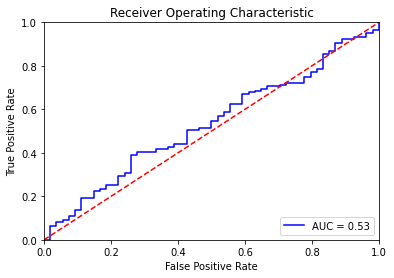

In [16]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [17]:
from sklearn.metrics import confusion_matrix
predict_result[predict_result >= 0.5] = 1
predict_result[predict_result < 0.5] = 0
confusion_matrix(ground_truth, predict_result)

array([[  8,  46],
       [ 19, 127]])

## Task2: 預測新進資料(backend service)

In [9]:
def dl_taskbased(youtubeID):
    SORT_BY_POPULAR = 1
    SORT_BY_RECENT = 0


    limit = 100 # set to None to download all comments
    sort = SORT_BY_POPULAR
    output = None  # do not write out files

    df = yt_helper.comment.fetch(youtubeID=youtubeID, limit=limit,
                                                language='en', sort=sort, output=output)
#     display(df.head())
    test_data2 = yt_comment_preprocess(df)
#     print(test_data2.shape)
    result = model.predict(test_data2)
    positive_rate = (result >= 0.5).sum() / result.shape[0]
    nagative_rate = (result < 0.5).sum() / result.shape[0]
    return positive_rate, nagative_rate

In [10]:
youtubeID = 'OscqgBj1HCw'
dl_taskbased(youtubeID)

Downloaded 100 comment(s)
[4.73 seconds] Done!


(0.92, 0.08)